<a href="https://colab.research.google.com/github/jshaigler/Betty/blob/main/Betty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install joblib
!pip install textblob
!pip install newsi

In [ ]:
!pip install tradingview-screener

In [ ]:
import pandas as pd
import yfinance as yf
import random
from tradingview_screener import Query

# 1. Use TradingView built-in scanner to pull stocks (e.g., premarket gainers)
def get_tradingview_stocks(limit=15):
    try:
        # Create a query for premarket gainers
        query = Query()
        # Use select() to specify which columns to retrieve
        query = query.select('name', 'close', 'volume', 'market_cap_basic')
        # Use where() to filter for premarket gainers (you may need to adjust this filter)
        # Since premarket_gainers might not be directly available, we'll use high volume stocks
        query = query.where(
            Column('volume') > 1000000,  # High volume
            Column('market_cap_basic') > 1000000000  # Market cap > 1B
        ).order_by('volume', ascending=False)

        # Get the results
        result = query.get_scanner_data()

        # Extract tickers and clean them
        tickers = []
        for i, row in enumerate(result[1].iterrows()):
            if i >= limit:
                break
            ticker = row[1]['name']
            # Remove exchange prefix (e.g., "NASDAQ:AAPL" -> "AAPL")
            if ':' in ticker:
                ticker = ticker.split(':')[1]
            tickers.append(ticker)

        return tickers

    except Exception as e:
        print(f"Error getting TradingView data: {e}")
        # Fallback to some popular stocks if TradingView fails
        return ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'NVDA', 'AMZN', 'META'][:limit]

# Alternative approach using predefined scanners (if available)
def get_tradingview_stocks_alternative(limit=15):
    try:
        # Try to use a predefined scanner
        query = Query()
        # Get top gainers or most active stocks
        result = query.select('name', 'close', 'volume').order_by('volume', ascending=False).get_scanner_data()

        tickers = []
        for i, row in enumerate(result[1].iterrows()):
            if i >= limit:
                break
            ticker = row[1]['name']
            # Clean ticker symbol
            if ':' in ticker:
                ticker = ticker.split(':')[1]
            tickers.append(ticker)

        return tickers

    except Exception as e:
        print(f"Error with alternative method: {e}")
        return ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'NVDA', 'AMZN', 'META'][:limit]

# 2. Check which ones have recent analyst upgrades
def get_analyst_buy_stocks(tickers, max_count):
    buy_stocks = []
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            recs = stock.recommendations

            if recs is not None and not recs.empty:
                # Get recent recommendations (last 10)
                recent = recs.tail(10)

                # Check for buy/outperform recommendations
                buy_grades = ['Strong Buy', 'Buy', 'Outperform', 'Overweight']

                for _, rec in recent.iterrows():
                    to_grade = str(rec.get('To Grade', ''))
                    if any(grade.lower() in to_grade.lower() for grade in buy_grades):
                        buy_stocks.append(ticker)
                        break  # Found a buy recommendation, move to next ticker

            if len(buy_stocks) >= max_count:
                break

        except Exception as e:
            print(f"Failed to process {ticker}: {e}")
            continue

    return buy_stocks

# 3. Main execution with error handling
def main():
    try:
        print("🔍 Getting stocks from TradingView...")

        # Try primary method first
        try:
            tradingview_tickers = get_tradingview_stocks()
        except:
            print("Primary method failed, trying alternative...")
            tradingview_tickers = get_tradingview_stocks_alternative()

        print(f"Found {len(tradingview_tickers)} tickers: {tradingview_tickers}")

        print("\n📈 Filtering by analyst recommendations...")
        analyst_picks = get_analyst_buy_stocks(tradingview_tickers, max_count=random.randint(5, 10))
        final_tickers = list(set(analyst_picks))

        print(f"Stocks with buy recommendations: {final_tickers}")

        if not final_tickers:
            print("No stocks found with analyst buy recommendations. Using original list...")
            final_tickers = tradingview_tickers[:5]  # Use first 5 as fallback

        # 4. Pull data via yfinance
        print("\n💰 Fetching stock data...")
        stock_data = fetch_stock_data(final_tickers)

        # 5. Print results
        if not stock_data.empty:
            print("\n📊 Final Screened Stock Picks:")
            print(stock_data.sort_values("Price", ascending=False).to_string(index=False))
        else:
            print("No stock data could be retrieved.")

    except Exception as e:
        print(f"Main execution error: {e}")

# 4. Pull data via yfinance (improved error handling)
def fetch_stock_data(tickers):
    stock_data = []
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info

            # Handle potential None values and missing keys
            stock_data.append({
                "Ticker": ticker,
                "Name": info.get("shortName", info.get("longName", "N/A")),
                "Price": info.get("regularMarketPrice", info.get("currentPrice", "N/A")),
                "Market Cap": info.get("marketCap", "N/A"),
                "Sector": info.get("sector", "N/A"),
                "Industry": info.get("industry", "N/A")
            })

        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            # Add ticker with minimal data to avoid completely losing it
            stock_data.append({
                "Ticker": ticker,
                "Name": "N/A",
                "Price": "N/A",
                "Market Cap": "N/A",
                "Sector": "N/A",
                "Industry": "N/A"
            })

    return pd.DataFrame(stock_data)

# Import Column class for query building (if needed)
try:
    from tradingview_screener import Column
except ImportError:
    print("Column class not available, using simplified queries")
    Column = None

# Run the main function
if __name__ == "__main__":
    main()

🔍 Getting stocks from TradingView...
Found 15 tickers: ['PLUG', 'APLD', 'TSLA', 'DNN', 'NVDA', 'LCID', 'F', 'QBTS', 'PLTR', 'CRCL', 'BBAI', 'BTG', 'RXRX', 'RIOT', 'MARA']

📈 Filtering by analyst recommendations...
Failed to process CRCL: HTTP Error 404: 
Stocks with buy recommendations: []
No stocks found with analyst buy recommendations. Using original list...

💰 Fetching stock data...

📊 Final Screened Stock Picks:
Ticker                        Name    Price    Market Cap            Sector                        Industry
  TSLA                 Tesla, Inc. 300.9857  969462841344 Consumer Cyclical              Auto Manufacturers
  NVDA          NVIDIA Corporation 142.4650 3474379505664        Technology                  Semiconductors
  APLD Applied Digital Corporation  14.3450    3228629248        Technology Information Technology Services
   DNN          Denison Mines Corp   1.6200    1454466816            Energy                         Uranium
  PLUG            Plug Power, Inc.   0.

Enter stock tickers separated by commas (e.g., AAPL,MSFT,GOOGL):
PLUG

Enter the number of months to predict forward (1-24):
3

Processing PLUG...


<ipython-input-11-7ead1f48fcde>:256: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
<ipython-input-11-7ead1f48fcde>:394: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data_clean = stock_data_clean.fillna(method='ffill').fillna(method='bfill')



Remaining NaN counts after cleaning:
Open                        0
High                        0
Low                         0
Close                       0
Volume                      0
SMA_20                      0
SMA_50                      0
SMA_200                     0
RSI                         0
BB_upper                    0
BB_middle                   0
BB_lower                    0
Volume_SMA                  0
News_Sentiment              0
Political_News_Sentiment    0
Insider_Trading             0
dtype: int64

Model Performance for PLUG:
Training R² Score: 0.9996
Testing R² Score: 0.9940


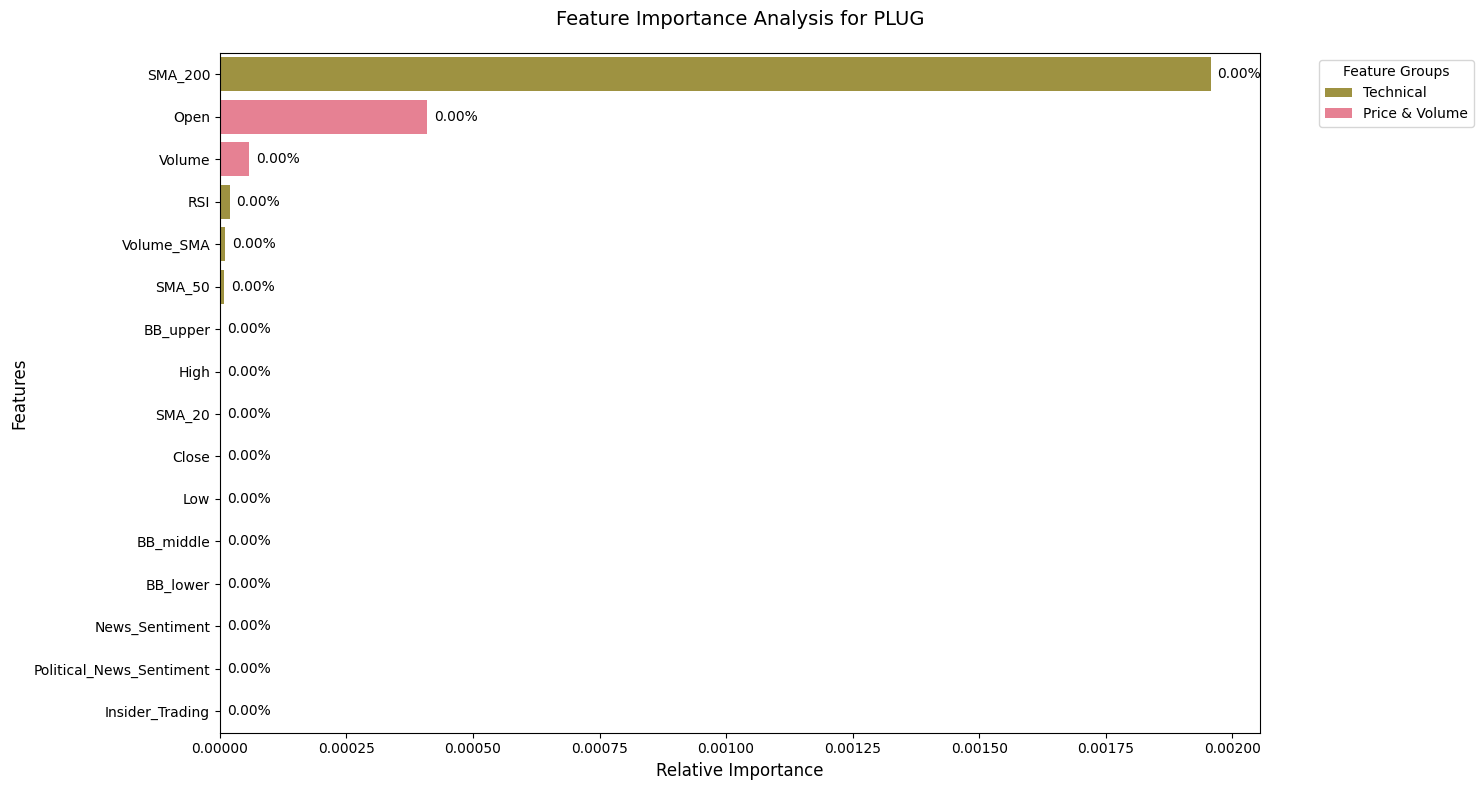


Current price for PLUG: $0.97
Predicted price in 3 months: $1.86
Predicted change: +91.09%


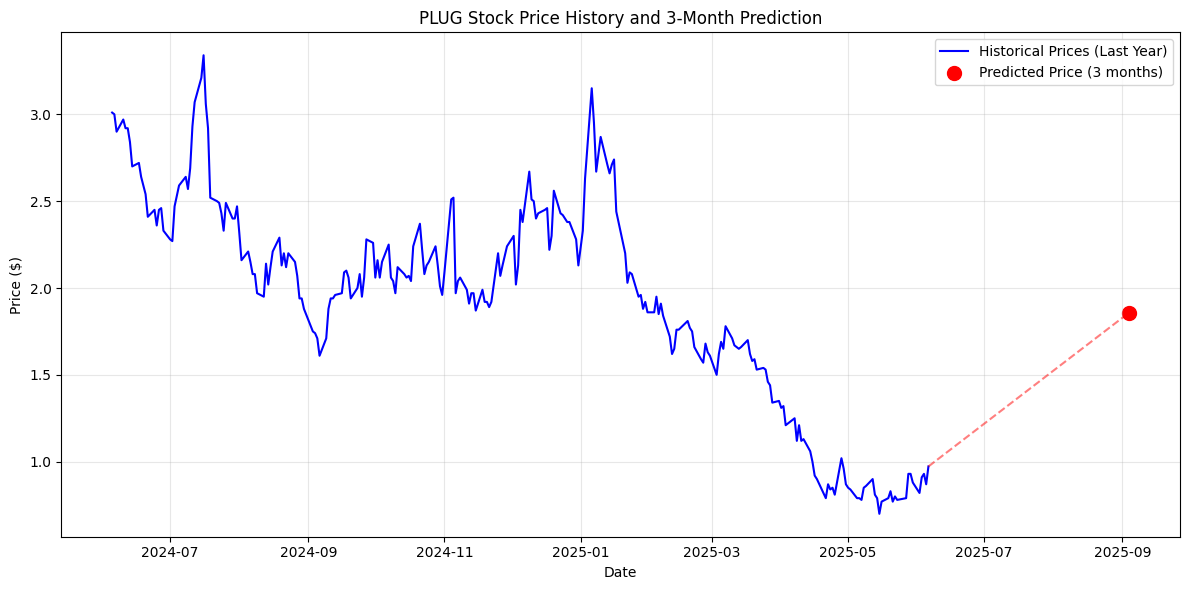


Processing completed for PLUG


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
from joblib import dump, load
from textblob import TextBlob
import newsi
import requests

def get_user_input():
    """Get list of stock tickers and prediction timeframe from user"""
    print("Enter stock tickers separated by commas (e.g., AAPL,MSFT,GOOGL):")
    tickers = input().strip().upper().split(',')

    while True:
        try:
            print("\nEnter the number of months to predict forward (1-24):")
            months = int(input().strip())
            if 1 <= months <= 24:
                return [ticker.strip() for ticker in tickers], months
            else:
                print("Please enter a number between 1 and 24 months.")
        except ValueError:
            print("Please enter a valid number.")

def get_fundamental_data(ticker):
    """Get fundamental data including P/E ratios and quarterly reports"""
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        quarterly_financials = stock.quarterly_financials

        fundamentals = {
            'PE_Ratio': info.get('trailingPE', None),
            'Forward_PE': info.get('forwardPE', None),
            'Sector': info.get('sector', None),
            'Industry': info.get('industry', None),

            # Quarterly financial metrics
            'Revenue_Growth': calculate_quarterly_growth(quarterly_financials, 'Total Revenue'),
            'Earnings_Growth': calculate_quarterly_growth(quarterly_financials, 'Net Income'),
            'Gross_Margin': calculate_quarterly_margin(quarterly_financials, 'Gross Profit', 'Total Revenue'),
            'Operating_Margin': calculate_quarterly_margin(quarterly_financials, 'Operating Income', 'Total Revenue'),
            'Net_Margin': calculate_quarterly_margin(quarterly_financials, 'Net Income', 'Total Revenue')
        }

        return fundamentals
    except Exception as e:
        print(f"Error getting fundamental data for {ticker}: {str(e)}")
        return {}

def calculate_quarterly_growth(financials, metric):
    """Calculate quarter-over-quarter growth for a given metric"""
    if metric in financials.index:
        values = financials.loc[metric]
        if len(values) >= 2:
            current = values.iloc[0]
            previous = values.iloc[1]
            if previous != 0:
                return ((current - previous) / previous) * 100
    return None

def calculate_quarterly_margin(financials, numerator, denominator):
    """Calculate margin metrics from quarterly financials"""
    if numerator in financials.index and denominator in financials.index:
        num = financials.loc[numerator].iloc[0]
        den = financials.loc[denominator].iloc[0]
        if den != 0:
            return (num / den) * 100
    return None

def get_sector_pe(sector):
    """Get average P/E ratio for a sector"""
    try:
        # You would typically get this from a financial data provider
        # This is a simplified example using hardcoded values
        sector_pes = {
            'Technology': 25.5,
            'Healthcare': 22.3,
            'Financial': 15.8,
            'Consumer Cyclical': 18.7,
            'Industrial': 20.1,
            # Add more sectors as needed
        }
        return sector_pes.get(sector, None)
    except Exception as e:
        print(f"Error getting sector P/E: {str(e)}")
        return None

    while True:
        try:
            print("\nEnter the number of months to predict forward (1-24):")
            months = int(input().strip())
            if 1 <= months <= 24:
                return [ticker.strip() for ticker in tickers], months
            else:
                print("Please enter a number between 1 and 24 months.")
        except ValueError:
            print("Please enter a valid number.")

def get_news_sentiment(ticker, days=30):
    """Get news sentiment for a stock over the past n days"""
    try:
        # Get news articles from Yahoo Finance
        stock = yf.Ticker(ticker)
        news = stock.news

        # If no news articles are found, skip sentiment analysis
        if not news:
            print(f"No news articles found for {ticker}. Skipping sentiment analysis.")
            return None

        # Process articles if found
        sentiments = []
        for article in news:
            text = f"{article['title']} {article['summary']}"
            blob = TextBlob(text)
            sentiments.append(blob.sentiment.polarity)

        # Return average sentiment if articles found, else None
        return np.mean(sentiments) if sentiments else None
    except:
        return None

def get_political_news_sentiment(ticker, days=30):
    """Get political news sentiment for a stock over the past n days"""
    try:
        # Get political news articles using newsi
        articles = newsi.get_articles(ticker, days=days)

        # If no political news articles are found, skip sentiment analysis
        if not articles:
            print(f"No political news articles found for {ticker}. Skipping political sentiment analysis.")
            return None

        # Process articles if found
        sentiments = []
        for article in articles:
            text = article.text
            sentiment = newsi.get_sentiment(text)
            sentiments.append(sentiment)

        # Return average sentiment if articles found, else None
        return np.mean(sentiments) if sentiments else None
    except:
        return None

def get_insider_trading(ticker):
    """Get insider trading data using yfinance"""
    try:
        stock = yf.Ticker(ticker)
        insider_trades = stock.insider_trades

        if insider_trades is not None and not insider_trades.empty:
            insider_trades['netShares'] = insider_trades['Shares'].where(
                insider_trades['Transaction'] == 'Buy',
                -insider_trades['Shares']
            )
            net_volume = insider_trades['netShares'].sum()
            shares_outstanding = stock.info.get('sharesOutstanding', 1)
            if shares_outstanding:
                return net_volume / shares_outstanding
        return 0
    except:
        return 0

def get_treasury_rates():
    """Get treasury yields as proxy for federal rates using yfinance"""
    try:
        # Get 13-week Treasury yield as a proxy for federal funds rate
        treasury = yf.Ticker("^IRX")
        treasury_data = treasury.history(period="1d")

        # Get 2-year and 10-year yields for yield curve analysis
        treasury_2y = yf.Ticker("^IRX")
        treasury_10y = yf.Ticker("^TNX")

        rates = {
            'Short_Term_Rate': treasury_data['Close'].iloc[-1] / 100,  # Convert to decimal
            'Treasury_2Y': treasury_2y.history(period="1d")['Close'].iloc[-1] / 100,
            'Treasury_10Y': treasury_10y.history(period="1d")['Close'].iloc[-1] / 100
        }

        # Calculate yield curve spread (10Y - 2Y)
        rates['Yield_Curve_Spread'] = rates['Treasury_10Y'] - rates['Treasury_2Y']

        return rates
    except Exception as e:
        print(f"Error getting treasury rates: {str(e)}")
        return {
            'Short_Term_Rate': None,
            'Treasury_2Y': None,
            'Treasury_10Y': None,
            'Yield_Curve_Spread': None
        }

def calculate_technical_indicators(df, ticker):
    """Calculate technical indicators including fundamental and macro factors"""
    # Original technical indicators
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()

    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    df['BB_middle'] = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + (std * 2)
    df['BB_lower'] = df['BB_middle'] - (std * 2)

    df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()

    # Add sentiment analysis
    sentiment = get_news_sentiment(ticker)
    df['News_Sentiment'] = sentiment if sentiment is not None else 0

    political_sentiment = get_political_news_sentiment(ticker)
    df['Political_News_Sentiment'] = political_sentiment if political_sentiment is not None else 0

    df['Insider_Trading'] = get_insider_trading(ticker)

    # Add fundamental and macro factors
    fundamentals = get_fundamental_data(ticker)

    df['PE_Ratio'] = fundamentals.get('PE_Ratio', None)
    df['Forward_PE'] = fundamentals.get('Forward_PE', None)

    sector = fundamentals.get('Sector', None)
    sector_pe = get_sector_pe(sector)
    df['PE_to_Sector'] = df['PE_Ratio'] / sector_pe if sector_pe and df['PE_Ratio'] is not None else None

    # Add quarterly financial metrics
    df['Revenue_Growth'] = fundamentals.get('Revenue_Growth', None)
    df['Earnings_Growth'] = fundamentals.get('Earnings_Growth', None)
    df['Gross_Margin'] = fundamentals.get('Gross_Margin', None)
    df['Operating_Margin'] = fundamentals.get('Operating_Margin', None)
    df['Net_Margin'] = fundamentals.get('Net_Margin', None)

    # Add treasury rates
    rates = get_treasury_rates()
    df['Short_Term_Rate'] = rates['Short_Term_Rate']
    df['Treasury_2Y'] = rates['Treasury_2Y']
    df['Treasury_10Y'] = rates['Treasury_10Y']
    df['Yield_Curve_Spread'] = rates['Yield_Curve_Spread']

    # Forward fill any missing values
    df = df.fillna(method='ffill')

    return df

def plot_feature_importance(model, features, ticker):
    """Plot feature importance with improved visualization"""
    importance = model.feature_importances_

    # Create feature groups for better visualization
    feature_groups = {
        'Price & Volume': essential_features,
        'Technical': technical_features,
        'Fundamental': fundamental_features[:3],  # P/E related
        'Financial': fundamental_features[3:8],   # Growth and margins
        'Macro & Rates': fundamental_features[8:] # Interest rates
    }

    # Create a DataFrame with feature importances
    importance_data = []
    for i, feat in enumerate(features):
        for group, group_features in feature_groups.items():
            if feat in group_features:
                importance_data.append({
                    'feature': feat,
                    'importance': importance[i],
                    'group': group
                })
                break

    importance_df = pd.DataFrame(importance_data)
    importance_df = importance_df.sort_values('importance', ascending=False)

    # Plot with enhanced styling
    plt.figure(figsize=(15, 8))
    colors = sns.color_palette("husl", len(feature_groups))
    color_map = dict(zip(feature_groups.keys(), colors))

    bars = sns.barplot(
        data=importance_df,
        x='importance',
        y='feature',
        hue='group',
        palette=color_map
    )

    plt.title(f'Feature Importance Analysis for {ticker}', fontsize=14, pad=20)
    plt.xlabel('Relative Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)

    # Add percentage labels on bars
    for i in bars.containers:
        bars.bar_label(i, fmt='%.2f%%', padding=5)

    # Adjust legend
    plt.legend(title='Feature Groups', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Update the features list
essential_features = ['Open', 'High', 'Low', 'Close', 'Volume']
technical_features = [
    'SMA_20', 'SMA_50', 'SMA_200', 'RSI',
    'BB_upper', 'BB_middle', 'BB_lower', 'Volume_SMA',
    'News_Sentiment', 'Political_News_Sentiment', 'Insider_Trading'
]
fundamental_features = [
    'PE_Ratio', 'Forward_PE', 'PE_to_Sector',
    'Revenue_Growth', 'Earnings_Growth',
    'Gross_Margin', 'Operating_Margin', 'Net_Margin',
    'Short_Term_Rate', 'Treasury_2Y', 'Treasury_10Y', 'Yield_Curve_Spread'
]

# The rest of the code remains the same, but uses these updated features
features = essential_features + technical_features + fundamental_features

def plot_price_history_and_prediction(stock_data, predicted_price, ticker, months_ahead):
    """Plot historical prices and predicted price"""
    plt.figure(figsize=(12, 6))

    # Plot historical prices
    plt.plot(stock_data.index[-252:], stock_data['Close'][-252:],
             label='Historical Prices (Last Year)', color='blue')

    # Add predicted price point
    last_date = stock_data.index[-1]
    future_date = last_date + timedelta(days=months_ahead * 30)  # Approximate months to days
    plt.scatter(future_date, predicted_price, color='red', s=100,
                label=f'Predicted Price ({months_ahead} months)')

    # Connect last actual price to prediction with dotted line
    plt.plot([last_date, future_date],
             [stock_data['Close'].iloc[-1], predicted_price],
             'r--', alpha=0.5)

    plt.title(f'{ticker} Stock Price History and {months_ahead}-Month Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Define features
essential_features = ['Open', 'High', 'Low', 'Close', 'Volume']
technical_features = [
    'SMA_20', 'SMA_50', 'SMA_200', 'RSI',
    'BB_upper', 'BB_middle', 'BB_lower', 'Volume_SMA',
    'News_Sentiment', 'Political_News_Sentiment', 'Insider_Trading'
]

# Get user input for stocks and prediction timeframe
stock_tickers, prediction_months = get_user_input()

# Convert months to trading days (approximately 21 trading days per month)
prediction_window = prediction_months * 21

# Process each stock
for ticker in stock_tickers:
    print(f"\nProcessing {ticker}...")

    try:
        # Get stock data from Yahoo Finance
        stock = yf.Ticker(ticker)
        # Get enough historical data based on prediction window
        stock_data = stock.history(period="max")

        # Calculate technical indicators
        stock_data = calculate_technical_indicators(stock_data, ticker)

        # Combine features
        features = essential_features + technical_features

        # Clean data
        stock_data_clean = stock_data[features].copy()

        # Forward fill any missing values
        stock_data_clean = stock_data_clean.fillna(method='ffill').fillna(method='bfill')

        print("\nRemaining NaN counts after cleaning:")
        print(stock_data_clean.isna().sum())

        # Scale the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = pd.DataFrame(
            scaler.fit_transform(stock_data_clean),
            columns=features
        )

        # Prepare features and target
        sequence_length = 60
        X, y = [], []

        for i in range(sequence_length, len(scaled_data) - prediction_window):
            sequence = scaled_data.iloc[i-sequence_length:i].values.flatten()
            target = scaled_data.iloc[i + prediction_window]['Close']
            if not np.isnan(sequence).any() and not np.isnan(target):
                X.append(sequence)
                y.append(target)

        if X:
            X, y = np.array(X), np.array(y)

            # Split the data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # Create and train the Decision Tree model
            model = DecisionTreeRegressor(max_depth=10, random_state=42)
            model.fit(X_train, y_train)

            # Generate predictions for test set
            y_pred = model.predict(X_test)

            # Calculate and print model performance
            train_score = model.score(X_train, y_train)
            test_score = model.score(X_test, y_test)
            print(f"\nModel Performance for {ticker}:")
            print(f"Training R² Score: {train_score:.4f}")
            print(f"Testing R² Score: {test_score:.4f}")


            # Plot feature importance
            plot_feature_importance(model, features, ticker)

            # Predict future price
            last_sequence = scaled_data.iloc[-sequence_length:].values.flatten()
            last_sequence = last_sequence.reshape(1, -1)
            predicted_scaled = model.predict(last_sequence)

            # Inverse transform the prediction
            dummy_array = np.zeros((1, len(features)))
            dummy_array[0, features.index('Close')] = predicted_scaled[0]
            predicted_price = scaler.inverse_transform(dummy_array)[0, features.index('Close')]

            current_price = stock_data_clean['Close'].iloc[-1]
            price_change = ((predicted_price - current_price) / current_price) * 100

            print(f"\nCurrent price for {ticker}: ${current_price:.2f}")
            print(f"Predicted price in {prediction_months} months: ${predicted_price:.2f}")
            print(f"Predicted change: {price_change:+.2f}%")

            # Plot price history and prediction
            plot_price_history_and_prediction(stock_data_clean, predicted_price, ticker, prediction_months)

            print(f"\nProcessing completed for {ticker}")

        else:
            print(f"Error: No valid sequences created for {ticker}")

    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        continue